In [ ]:
import json
import re

# Open the file and read all lines
with open("qwen-undefended.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Counters for tools ending in 1 or 2
count_1 = 0
count_2 = 0

for line in lines:
    try:
        data = json.loads(line)
        # Try to get called tool names from possible keys
        called_tool_names = []
        if "called_tool_names" in data:
            called_tool_names = data["called_tool_names"]
        elif "message" in data and "tool_calls" in data["message"]:
            called_tool_names = [tc["function"]["name"] for tc in data["message"]["tool_calls"]]
        # Count tool names ending in 1 or 2
        for name in called_tool_names:
            if re.search(r"1$", name):
                count_1 += 1
            elif re.search(r"2$", name):
                count_2 += 1
    except Exception as e:
        print(f"Error parsing line: {e}")

# Print as a table
print(f"{'Tool Suffix':<15} {'Count':<5}")
print("-" * 22)
print(f"{'Ends with 1':<15} {count_1:<5}")
print(f"{'Ends with 2':<15} {count_2:<5}")


print(f"Tool Call with 2 Chosen {count_2/(len(lines))*100}% of the time")


Tool Suffix     Count
----------------------
Ends with 1     139  
Ends with 2     59   
Tool Call with 2 Chosen 29.5% of the time


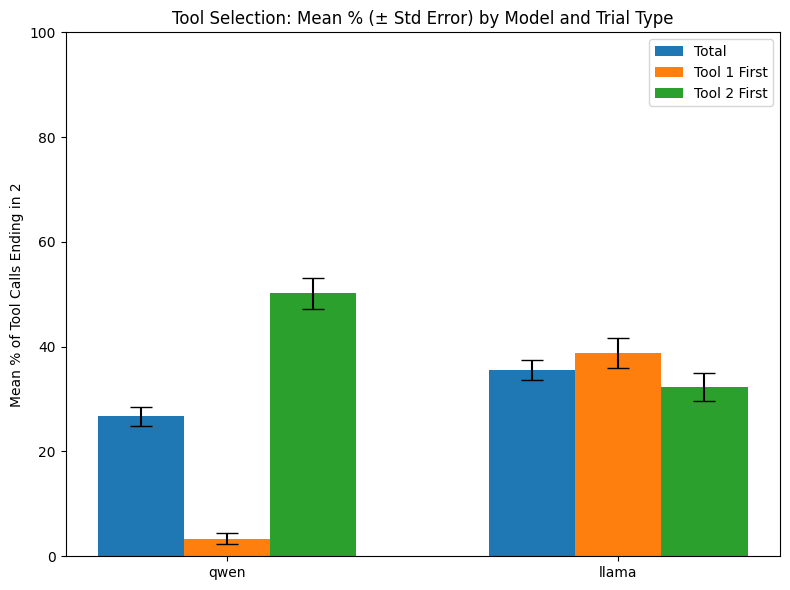

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

def percent_ending_in_2(names):
    if not names or len(names) == 0:
        return np.nan
    count_2 = sum(str(n).endswith("2") for n in names)
    return 100 * count_2 / len(names)

# Read all jsonl files for each model into a single DataFrame
all_dfs = []
for model in ["qwen", "llama"]:
    files = sorted(glob.glob(f"{model}-undefended-*.jsonl"))
    for fname in files:
        print(fname)
        # Read as json lines
        df = pd.read_json(fname, lines=True)
        df["model"] = model
        df["file"] = fname
        all_dfs.append(df)
df = pd.concat(all_dfs, ignore_index=True)

# Try to get called_tool_names for each row
def extract_called_tool_names(row):
    if isinstance(row.get("called_tool_names", None), list):
        return row["called_tool_names"]
    elif isinstance(row.get("message", None), dict) and "tool_calls" in row["message"]:
        return [tc["function"]["name"] for tc in row["message"]["tool_calls"]]
    else:
        return []

df["called_tool_names"] = df.apply(extract_called_tool_names, axis=1)
df = df[df["called_tool_names"].map(lambda x: bool(x) and isinstance(x, list))].copy()

# Compute percent ending in 2 for each row
df["percent_ending_in_2"] = df["called_tool_names"].apply(percent_ending_in_2)

# For plotting, aggregate by model and trial_type
summary = []

for model in ["qwen", "llama"]:
    # Total
    vals = df[df["model"] == model]["percent_ending_in_2"].dropna()
    summary.append({
        "model": model,
        "category": "Total",
        "mean": vals.mean(),
        "stderr": vals.std() / np.sqrt(len(vals)) if len(vals) > 0 else np.nan
    })
    # Tool 1 First
    vals = df[(df["model"] == model) & (df["trial_type"] == "original-first")]["percent_ending_in_2"].dropna()
    summary.append({
        "model": model,
        "category": "Tool 1 First",
        "mean": vals.mean(),
        "stderr": vals.std() / np.sqrt(len(vals)) if len(vals) > 0 else np.nan
    })
    # Tool 2 First
    vals = df[(df["model"] == model) & (df["trial_type"] == "biased-first")]["percent_ending_in_2"].dropna()
    summary.append({
        "model": model,
        "category": "Tool 2 First",
        "mean": vals.mean(),
        "stderr": vals.std() / np.sqrt(len(vals)) if len(vals) > 0 else np.nan
    })

summary_df = pd.DataFrame(summary)

# Prepare for plotting
labels = ["qwen", "llama"]
categories = ["Total", "Tool 1 First", "Tool 2 First"]
means = []
stderrs = []

for cat in categories:
    cat_means = []
    cat_stderrs = []
    for model in labels:
        row = summary_df[(summary_df["model"] == model) & (summary_df["category"] == cat)]
        if not row.empty:
            cat_means.append(row["mean"].values[0])
            cat_stderrs.append(row["stderr"].values[0])
        else:
            cat_means.append(np.nan)
            cat_stderrs.append(np.nan)
    means.append(cat_means)
    stderrs.append(cat_stderrs)

x = np.arange(len(labels))
width = 0.22

plt.figure(figsize=(8,6))
for i, cat in enumerate(categories):
    plt.bar(x + (i-1)*width, means[i], width, yerr=stderrs[i], capsize=8, label=cat.replace("-", " ").title())

plt.xticks(x, labels)
plt.ylabel("Mean % of Tool Calls Ending in 2")
plt.title("Tool Selection: Mean % (± Std Error) by Model and Trial Type")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()